Include all the packages needed for this exercise as reported below

In [7]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math 
import statsmodels.api as sm
import sklearn
from sklearn.neighbors import KernelDensity
from scipy.integrate import nquad
import uproot
import pandas

Define two classes where one defines the caracteristics of a sample (name, sample identification and cross-section), the other defines which setup to be fitted (center of the ellipse, radius or both) 

In [8]:
class Sample:
    def __init__(self, name, sample_id, xs):
        self.name = name
        #self.file = file
        self.sample_id = sample_id
        self.xs = xs
        
class FitSetup:
    x0y0 = 1
    ab = 2
    x0y0ab = x0y0 + ab

In the following parts open the files, called "anaTuples", where already a selection is applied (Central energy scale).

Specify for the two samples we want to analyze, Signal SM and TT, their cross-sections and their sample id (please refer to the exercise of significance estimation).

In [10]:
#path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/eventTuples/"
#path = "/Users/Tita/Desktop/files_school/"
#path = "/Volumes/Silver/cms-das-2019/hh_bbtautau/eventTuples/"

#path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/anaTuples/"
path = "/Users/Tita/Desktop/Run2_analysis_hh_bbtautau/anaTuples/"
#path = "./anaTuples/"

anaTuples = {'eTau': "eTau_tuple.root", 'muTau': "muTau_tuple.root", 'tauTau': "tauTau_tuple.root"} 
channel = "tauTau"

sample_list = [
    Sample("Signal", -125, 0.03353 * 2 * 5.809e-01 * 6.256e-02),
    Sample("TT", 1, 831.76)
]

with uproot.open(path+anaTuples[channel]) as file:
        tree = file[channel]
        df = tree.arrays('*', outputtype=pandas.DataFrame)    
        sample.total_weight = np.sum(df.weight)

samples = {}
for sample in sample_list:
    samples[sample.name] = sample
    
    

Make the plot for both Signal and TT of mass of Higgs into bb candidate and of Higgs into tau pair candidate, in order to view the different behaviour of the signal and of the background. What can you notice?

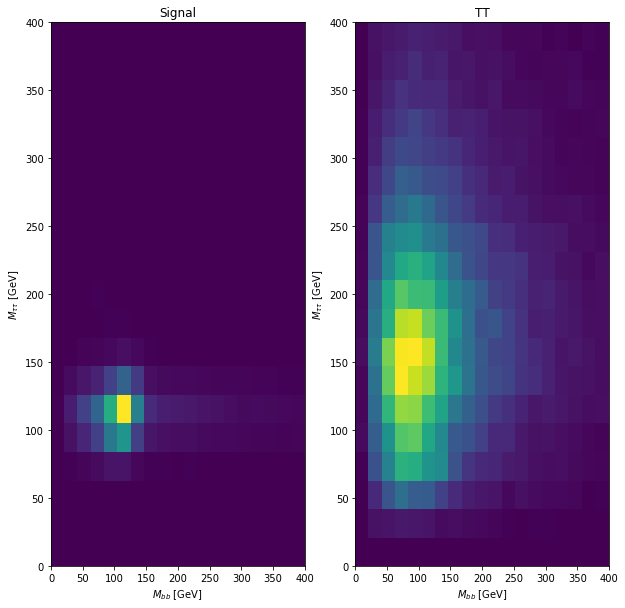

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

n = 0
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
for sample in sample_list:
    ax[n].hist2d(df[(df.sample_id == sample.sample_id)].m_bb, df[(df.sample_id == sample.sample_id)].m_sv, 
                 weights=df[(df.sample_id == sample.sample_id)].weight, bins=[bins_x, bins_y])
    ax[n].set_xlabel(r'$M_{bb}$ [GeV]')
    ax[n].set_ylabel(r'$M_{\tau\tau}$ [GeV]')
    ax[n].set_title(sample.name)
    
    n += 1
#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)
plt.show()

Look at the code for the minimization of the ellipse cut around mbb and mtautau. Here it is first calculated how to do it with 2 paramenters (the center of the ellipse or the radius of the ellipse), then also there is the possiblity to have a fit of 4 parameters

In [30]:
class EllipseMinimization( ROOT.TPyMultiGenFunction ):
    def __init__( self, samples, x0, y0, a, b, fit_setup):
        self.samples = samples
        self.x0 = x0
        self.y0 = y0
        self.a = a
        self.b = b
        self.fit_setup = fit_setup
        ROOT.TPyMultiGenFunction.__init__( self, self )

    def NDim(self):
        if self.fit_setup == FitSetup.x0y0ab:
            return 4
        return 2

    def DoEval(self, args):
        n = 0
        x0 = self.x0
        y0 = self.y0
        a = self.a
        b = self.b

        if self.fit_setup & FitSetup.x0y0 != 0:
            x0 = args[0]
            y0 = args[1]
            n = 2
        if self.fit_setup & FitSetup.ab != 0:
            a = args[n]
            b = args[n+1]
        
        n_signal = self.CalcNumEvents('Signal', x0, y0, a, b)
        n_bkg = self.CalcNumEvents('TT', x0, y0, a, b)
        print(n_signal,n_bkg)
        
        #target = -n_signal / math.sqrt(n_bkg) # better formula
        #Discovery sensitivity for a counting experiment with background uncertainty
        #target = math.sqrt(2*((n_signal+n_bkg)*math.log(1 + (n_signal/n_bkg)) - n_signal))
        target = -n_signal/math.sqrt(n_signal+n_bkg)
        #print("target = ", target)
        return target
        
    def CalcNumEvents(self, sample_name, x0, y0, a, b):
        sample = self.samples[sample_name]
        x = df.m_bb
        y = df.m_sv
        weight = df.weight
        inside_ellipse = ((x - x0) / a)**2 + ((y - y0) / b) ** 2 < 1
        n_inside = np.sum(inside_ellipse * weight)
        return n_inside / sample.total_weight * sample.xs

In [31]:
def FindParams(samples, x0, y0, a, b, fit_setup):
    minimizer = ROOT.Math.Factory.CreateMinimizer("Minuit", "Combined")
    minimizer.SetTolerance(0.05)
    minimizer.SetPrintLevel(2)
    minimizer.SetStrategy(2)
    ellipse = EllipseMinimization(samples, x0, y0, a, b, fit_setup)

    minimizer.SetFunction(ellipse)

    # Set the variables to be minimized!
    c_factor = 0.1
    r_factor = 5.0
    n = 0
    if fit_setup & FitSetup.x0y0 != 0:
        minimizer.SetLimitedVariable(0, "x0", x0, 1, x0 * (1 - c_factor), x0 * (1 + c_factor))
        minimizer.SetLimitedVariable(1, "y0", y0, 1, y0 * (1 - c_factor), y0 * (1 + c_factor))
        n = 2
    if fit_setup & FitSetup.ab != 0:
        minimizer.SetLimitedVariable(n, "a", a, 0.1, max(2, a * (1 - r_factor)), a * (1 + r_factor))
        minimizer.SetLimitedVariable(n + 1, "b", b, 0.1, max(2, b * (1 - r_factor)), b * (1 + r_factor))
        
    minimizer.Minimize()
    #result = [x for ix in minimizer.X()]
    result = [minimizer.X()[i] for i in range(ellipse.NDim())]
    return tuple(result)

Now you have to choose a starting point for the minimization. Here following it is for the center values, taking the indices of the maximum values for the mass candidate and their bin extremis.

In [32]:
sgn_id = samples["Signal"].sample_id
hist, bin_edges = np.histogram(df[(df.sample_id == sgn_id)].m_bb, bins=200, range=(0, 200))
max_bin = np.argmax(hist)
x0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
hist, bin_edges = np.histogram(df[(df.sample_id == sgn_id)].m_sv, bins=200, range=(0, 200))
max_bin = np.argmax(hist)
y0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
print(x0, y0)

115.5 114.5


Here following it is for the radius values using the percentiles.

In [33]:
interval = np.percentile(df[(df.sample_id == sgn_id)].m_bb, [25, 75])
a = max(x0 - interval[0], interval[1] - x0)
interval = np.percentile(df[(df.sample_id == sgn_id)].m_sv, [25, 75])
b = max(y0 - interval[0], interval[1] - y0)
print(a, b)

23.739181518554688 12.567741394042969


Calculate new center parameters starting from the calculated one

In [36]:
new_x0, new_y0 = FindParams(samples, x0, y0, a, b, FitSetup.x0y0)
print(new_x0, new_y0)

0.0001524493471879877 52.03097142803573
0.0001524493471879877 52.03097142803573
0.00015225880636873424 51.96593983488482
0.00015256028376352772 52.06883408798619
0.00014510060675268724 49.52284587240661
0.00015428967233843487 52.659074513338794
0.00015240291859414993 52.01512534614705
0.00015264646081329276 52.09824632029012
0.00014206084650231356 48.48537551485735
0.00015181527750839175 51.81456340798853
0.00015151014815228297 51.71042274026908
0.0001537915358816382 52.4890605104655
0.00015227924556181457 51.97291573272099
0.00015279416665619225 52.14865833341721
0.00015233083082953592 51.99052178771844
0.00015246826922040024 52.03742951884411
0.0001519123757770639 51.84770305296689
0.00015331107677893152 52.3250797896137
0.00015234988519194885 51.997025042763966
0.0001528647967522579 52.17276438948198
0.0001360189366711319 46.423271323559426
0.00015599484678072256 53.2410506537619
0.0001565197662760499 53.420205709307766
0.00015615907521788163 53.297101829310435
0.0001563173822225583

Calculate new radius parameters starting from the starting point for radius and the calculated one for centers

In [37]:
new_a, new_b = FindParams(samples, new_x0, new_y0, a, b, FitSetup.ab)
print(new_a, new_b)

0.0001565197662760499 53.420205709307766
0.0001565197662760499 53.420205709307766
0.0001565604968968018 53.43410707263716
0.00015646464271430212 53.40139203434481
0.0001613452594175361 55.067146810742905
0.00015125439523451794 51.62313425394674
0.000271374658856037 92.62018750280346
3.856405876134296e-05 13.16191559079783
0.00015662259704801382 53.45530185800679
0.00015641342761892852 53.38391231919206
0.0001668329841970995 56.94010761036046
0.00014526614276522937 49.57934332351258
0.0002852446119449012 97.35400333203748
4.553877417692819e-05 15.542386384546106
0.00018093011560183056 61.75145941255841
0.00012943934524080187 44.17765636990862
0.00018383140578412011 62.741669927484395
0.00012862558233497996 43.89991904086775
0.00016147814813857625 55.112501739282024
0.0001506729232956999 51.42467784601251
0.000509971819084087 174.0534127387744
0.0010718985762412877 365.8390489884446
0.00013199930437187712 45.051370576383164
3.992987955687441e-05 13.628070311030791
0.0002527036482758066 8

Calculate the final parameters fitting the 4 paramteres starting from the center and radius values obtained by previus fit

In [25]:
final_x0, final_y0, final_a, final_b = FindParams(samples, new_x0, new_y0, new_a, new_b, FitSetup.x0y0ab)
print(new_x0, new_y0, new_a, new_b)
print(final_x0, final_y0, final_a, final_b)

110.0454686912325 112.52788696125542 142.43506250789133 64.2730117859536
101.61572589942878 123.54529331316098 341.7983928224237 375.8856834826345
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x0           1.10045e+02  1.00000e+00    9.90409e+01  1.21050e+02
     2 y0           1.12528e+02  1.00000e+00    1.01275e+02  1.23781e+02
     3 a            1.42435e+02  1.00000e-01    2.00000e+00  8.54610e+02
     4 b            6.42730e+01  1.00000e-01    2.00000e+00  3.85638e+02
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           2
 **********
 NOW USING STRATEGY  2: MAKE SURE MINIMUM TRUE, ERRORS CORRECT  
 **********
 **    6 **MIGRAD           0        0.05
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MIN